In [4]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from queso_model import model_data, model_vars, objective_func, balance

### Datos
Información que obtiene el modelo del sistema de información

In [86]:
# # Demanda
# DEMANDA = 60
# # Costo por unidad de tiempo
# CTIEMPO = 100
# # Tiempo máximo definido
# T_MAX = 360
# # Parámetros de entrada
# params_df = pd.read_excel('./data/' + 'nuevo_info_acopios.xlsx')
# # Matriz de costos de transporte
# trans_cost_df = pd.read_excel('./data/' + 'costoTransporteCAi.xlsx', index_col=0)
# # Matriz de tiempos de transporte
# trans_time_df = pd.read_excel('./data/' + 'tiempoTransporteCAi.xlsx', index_col=0)

### Variables
Definición de variables para el modelo

In [87]:
# # Número de centros de acopio
# N = params_df.shape[0]
# 
# # Vector de representación
# CAPACIDADES = np.empty(N*2, dtype=float)
# 
# # Capacidades en stock y potencial por centro de acopio
# for cap_i in range(0, N*2, 2):
#     CAPACIDADES[cap_i] = params_df['Stock'].iloc[cap_i//2]
#     CAPACIDADES[cap_i+1] = params_df['Ppotencial'].iloc[cap_i//2]
#     
# CAPACIDADES = np.append(CAPACIDADES, N-1)

### Parámetros

Para las operaciones de optimización

In [88]:
# parámetros de SA y GA

In [89]:
# def get_delta(x, i, idx_acopio, idx_principal=-1):
#     kca = x[i] + x[i + 1]
#     precio = params_df['Precio'].iloc[idx_acopio]
#     talistam = 0
# 
#     if x[i + 1]:
#         talistam = params_df['TiempoAlistam'].iloc[idx_acopio]
# 
#     ' Si es el centro de acopio principal (idx_principal=-1) '
#     if idx_principal < 0:
#         ctransp = params_df['Ctransp'].iloc[idx_acopio]
#         ttransp = params_df['TiempoTransp'].iloc[idx_acopio]
#         tiempo = talistam + ttransp
# 
#         return (kca * precio) + ctransp + (tiempo * CTIEMPO)
#     else:
#         ctransp = trans_cost_df.iloc[idx_acopio, idx_principal]
#         ttransp = trans_time_df.iloc[idx_acopio, idx_principal]
#         tiempo = talistam + ttransp
# 
#         return (kca * precio) + ctransp + (tiempo * CTIEMPO)

In [90]:
# def f(x):
#     delta = 0
#     idx_principal = int(x[N*2])
# 
#     for i in range(0, N*2, 2):
#         idx_acopio = i//2
# 
#         if x[i] == 0 and x[i+1] == 0:
#             continue
# 
#         if idx_acopio == idx_principal:
#             # Única suma de kCAp
#             delta += get_delta(x, i, idx_acopio)
#             continue
#             
#         # Sumas con kCAi
#         delta += get_delta(x, i, idx_acopio, idx_principal)
# 
#     return delta

Función que altera el vector para que cumpla con la restricción de igualdad

In [91]:
# def balance(individual, delta, diff):
#     delta = np.squeeze(delta)
#     
#     # Reducir para igualar a la demanda
#     if diff:
#         acopios = list(np.nonzero(individual)[0])
# 
#         while delta > 0 and len(acopios) > 0:
#             idx = np.random.choice(acopios)
#             acopios.remove(idx)
# 
#             if delta <= individual[idx]:
#                 individual[idx] -= delta
#                 delta = 0
#             else:
#                 delta -= individual[idx]
#                 individual[idx] = 0
#     # Aumentar para igualar a la demanda
#     else:
#         acopios = list(np.where(individual == 0)[0])
# 
#         while delta > 0 and len(acopios) > 0:
#             idx = np.random.choice(acopios)
#             acopios.remove(idx)
# 
#             if delta <= CAPACIDADES[idx]:
#                 individual[idx] = delta
#                 delta = 0
#             else:
#                 individual[idx] = CAPACIDADES[idx]
#                 delta -= CAPACIDADES[idx]

# Enfriamiento Simulado

In [5]:
archivos = {
    'info_acopios': 'nuevo_info_acopios.xlsx',
    'costo_transporte' : 'costoTransporteCAi.xlsx',
    'tiempo_transporte' : 'tiempoTransporteCAi.xlsx',
}

data = model_data(archivos)

demanda = data['demanda']
ctiempo = data['ctiempo']
# t_max = data['t_max']
params_df = data['params_df']

N, seed, capacidades = model_vars(params_df)

## Generación
De nuevas posibles soluciones

In [6]:
# Generador del estado inicial
def gen_s0(n_vars):
    # Se indexan los centros de acopio
    gen_vector = np.zeros(n_vars+1, dtype=float)

    # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
    indices = np.arange(n_vars)
    np.random.shuffle(indices)

    while np.sum(gen_vector) < demanda and indices.size > 0:
        idx = indices[0]
        gen_vector[idx] += capacidades[idx]
        indices = np.delete(indices, 0)

        if np.sum(gen_vector) > demanda:
            gen_vector[idx] = gen_vector[idx] - (np.sum(gen_vector) - demanda)
            break

    gen_vector[n_vars] = np.random.randint(capacidades[n_vars] + 1)

    return gen_vector

In [93]:
# def gen_s(self, problem, X):
#     for i in range(len(X)):
#         r = np.random.random()
# 
#         if r < self.prob:
#             # Se toma un índice aleatorio
#             individual = X[i]
#             idx_mut = np.random.randint(individual.shape)
# 
#             # Si es el índice del centro de acopio principal (N*2)
#             if idx_mut == N*2:
#                 X[i, problem.n_var-1] = np.random.randint(CAPACIDADES[N*2] + 1)
# 
#             else:
#                 if individual[idx_mut] == 0:
#                     # Se asigna la máxima cantidad posible del índice
#                     delta = CAPACIDADES[idx_mut]
#                     individual[idx_mut] = CAPACIDADES[idx_mut]
#                     diff = True
#                 else:
#                     # Se asigna cero a la cantidad del índice
#                     delta = individual[idx_mut]
#                     individual[idx_mut] = 0
#                     diff = False
# 
#                 balance(individual, delta, diff)
# 
#                 for j in range(individual.shape[0]):
#                     X[i, j] = individual[j]
# 
#     return X

Pseudocódigo del método de enfriamiento simulado implementado:

$$
\textit{Sea } s = s_0 \\ 
\textit{Mientras } t > t_{min}, e > e_{th}: \\
\qquad \text{Generar una nueva solución aleatoria, } s_{new} \leftarrow genS(s) \\ 
\qquad \textit{Si } f(s) > f(s_{new}): \\
\qquad \qquad \textit{entonces } s \leftarrow s_{new} \\
\qquad \textit{Sino:} \\
\qquad \qquad \textit{Si } P(f(s), f(s_{new}), t) \geq rand(0, 1): \\ 
\qquad \qquad \qquad \textit{entonces } s \leftarrow s_{new} \\
\text{Salida: } s_{final}
$$

In [10]:
def anneal(t, t_min, e_th, alpha):
    size = capacidades.shape[0] - 1
    # Función objetivo
    f = objective_func
    # Estado inicial (s0)
    s = gen_s0(N*2)
    # función objetivo a minimizar (a.k.a energía, fitness)
    e = f(s, N, data)
    # Contador de iteraciones o pasos
    k = 0

    while t > t_min and e > e_th:
        s_new = gen_s0(size)
        e_new = f(s_new, N, data)

        delta = e_new - e

        if delta < 0:
            s = s_new
            e = e_new
        else:
            asd = -delta / t
            p = np.exp(asd)
            r = np.random.rand()

            if r < p:
                s = s_new
                e = e_new

        t *= alpha
        k += 1

    return s, k


def sa(t_max, t_min, e_th, alpha, seed=1):
    np.random.seed(seed)
    x, count = anneal(t_max, t_min, e_th, alpha)
    print(f'Count: ', count)
    return x


## Aplicación

In [11]:
' Enfriamiento simulado '

# Temperatura inicial
max_anneal = 1e4
# Temperatura final de enfriamiento (terminación)
min_anneal = 1e-9
# Energía mínima (terminación)
energy = 1e-6
# Ratio de enfriamiento
r_anneal = 0.995

In [12]:
t_start_sa = timeit.default_timer()
sa = sa(max_anneal, min_anneal, energy, r_anneal)
t_end_sa = timeit.default_timer()

t_delta_sa = t_end_sa - t_start_sa
sa

Count:  5972


array([10. ,  0. , 12. ,  0. ,  0. ,  0. ,  8. , 13. ,  0. ,  0. ,  0. ,
        0. ,  4.5,  0. ,  0. , 12.5,  0. ,  0. ,  0. ,  0. ,  5. ])

In [97]:
# print_acopios(sa)
print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(sa[N*2])]}')
print(f'Precio: {objective_func(sa, N, data)}')
print(f'Tiempo: {round(t_delta_sa * 1000)}ms, ({t_delta_sa})')

Centro de acopio principal: CA6
Precio: 437103.0
Tiempo: 2938ms, (2.9381939000450075)


# Resultados (SA)

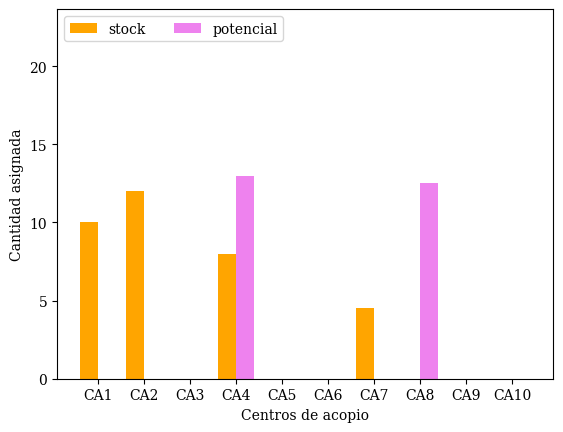

In [98]:
even = np.arange(0, N*2-1, 2)
odd = np.arange(1, N*2, 2)

cap_stock = np.take(capacidades, even)
cap_potencial = np.take(capacidades, odd)

ca_stock = np.take(sa, even)
ca_potencial = np.take(sa, odd)
    
labels = params_df['Id_CA']
x = np.arange(len(labels))
y1 = ca_stock
y2 = ca_potencial

fig, ax = plt.subplots()
y_lim = np.array(np.mean([np.max(capacidades), np.max(sa)])) * 1.1
ax.set_ylim([0, y_lim])
x1_bar = ax.bar(x-0.2, y1, width=0.4, label='stock', color='orange')
x2_bar = ax.bar(x+0.2, y2, width=0.4, label='potencial', color='violet')

plt.xticks(x, labels)
plt.xlabel('Centros de acopio')
plt.ylabel('Cantidad asignada')
plt.legend(loc='upper left', ncol=2)
plt.show()

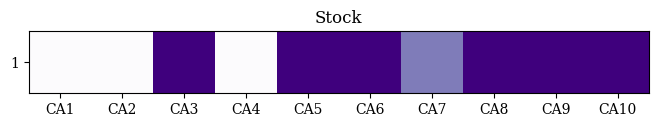

In [99]:
from pymoo.visualization.heatmap import Heatmap

ca_stock_norm = ca_stock / cap_stock
heatmap = Heatmap(bounds=(0, 1),
                  title='Stock',
                  cmap='Purples',
                  labels=labels.values.tolist())
heatmap.add(ca_stock_norm)
heatmap.show()

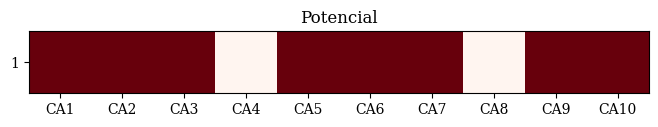

In [100]:
ca_potencial_norm = ca_potencial / cap_potencial
heatmap = Heatmap(bounds=(0, 1),
                  title='Potencial',
                  cmap='Reds',
                  labels=labels.values.tolist())
heatmap.add(ca_potencial_norm)
heatmap.show()

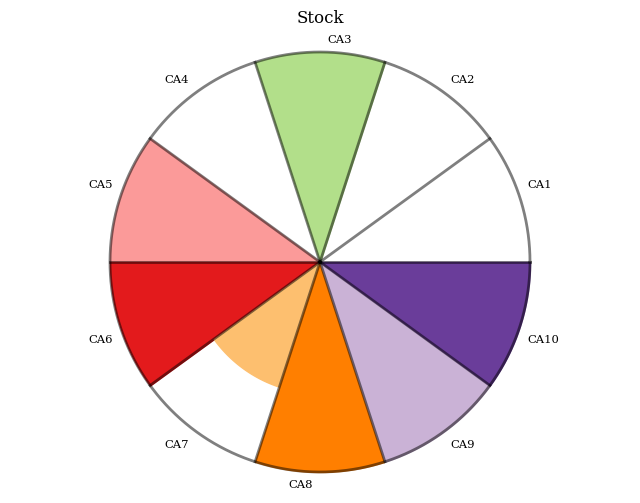

In [101]:
from pymoo.visualization.petal import Petal

petal = Petal(bounds=(0, 1),
              cmap='Paired',
              title='Stock',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_stock_norm)
petal.show()

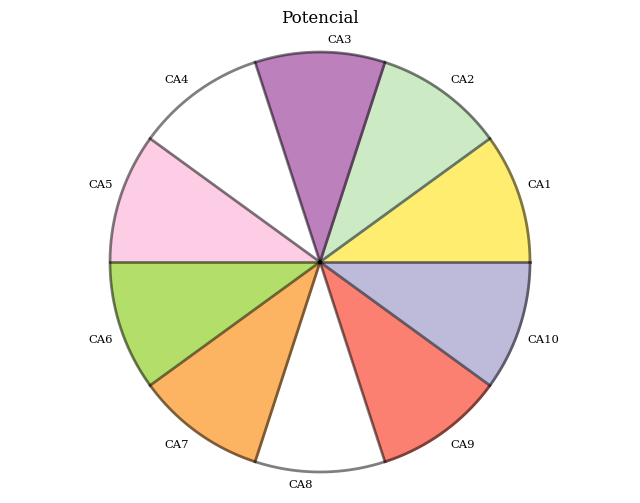

In [102]:
petal = Petal(bounds=(0, 1),
              cmap='Set3_r',
              title='Potencial',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_potencial_norm)
petal.show()

# Resultados (GA)

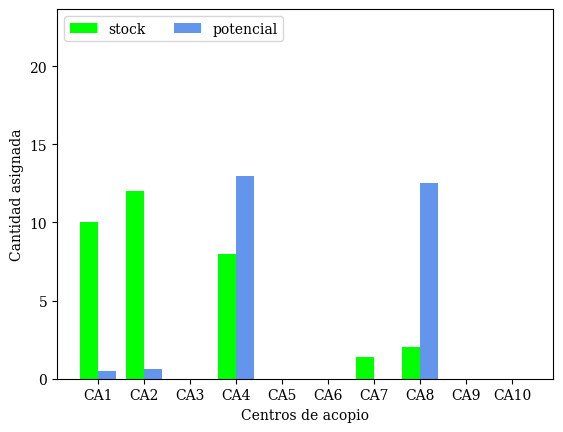

In [103]:
ca_stock = np.take(ga.X, even)
ca_potencial = np.take(ga.X, odd)

x = np.arange(len(labels))
y1 = ca_stock
y2 = ca_potencial

fig, ax = plt.subplots()
y_lim = np.array(np.mean([np.max(capacidades), np.max(ga.X)])) * 1.1
ax.set_ylim([0, y_lim])
x1_bar = ax.bar(x-0.2, y1, width=0.4, label='stock', color='lime')
x2_bar = ax.bar(x+0.2, y2, width=0.4, label='potencial', color='cornflowerblue')

plt.xticks(x, labels)
plt.xlabel('Centros de acopio')
plt.ylabel('Cantidad asignada')
plt.legend(loc='upper left', ncol=2)
plt.show()

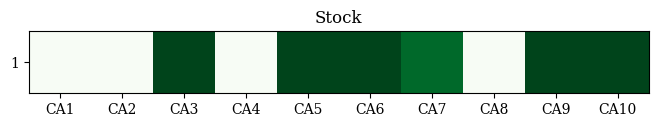

In [104]:
ca_stock_norm = ca_stock / cap_stock
heatmap = Heatmap(bounds=(0, 1), 
                  title='Stock', 
                  cmap='Greens', 
                  labels=labels.values.tolist())
heatmap.add(ca_stock_norm)
heatmap.show()

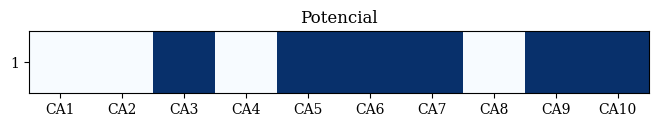

In [105]:
ca_potencial_norm = ca_potencial / cap_potencial
heatmap = Heatmap(bounds=(0, 1), 
                  title='Potencial', 
                  cmap='Blues', 
                  labels=labels.values.tolist())
heatmap.add(ca_potencial_norm)
heatmap.show()

testing https://pymoo.org/visualization/heatmap.html

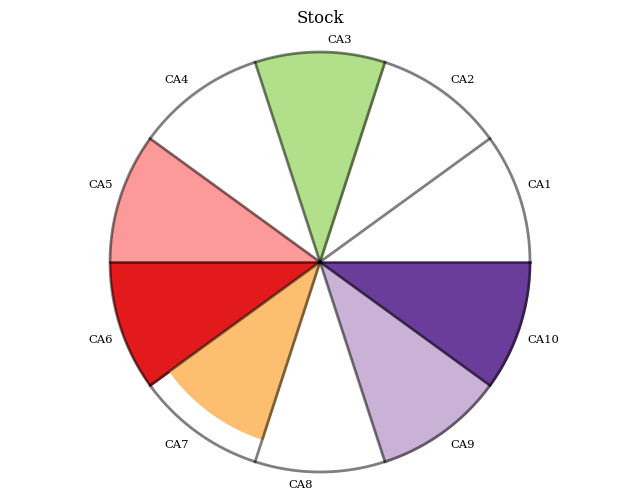

In [106]:
petal = Petal(bounds=(0, 1), 
              cmap='Paired', 
              title='Stock',
              labels=labels.values.tolist(), 
              reverse=True)
petal.add(ca_stock_norm)
petal.show()

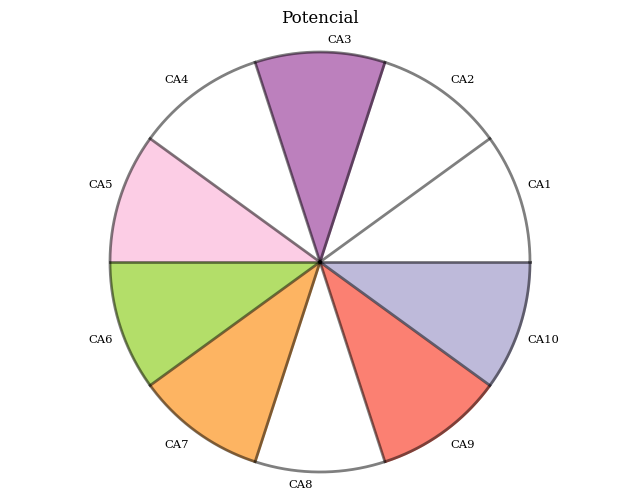

In [107]:
petal = Petal(bounds=(0, 1), 
              cmap='Set3_r',
              title='Potencial',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_potencial_norm)
petal.show()

# todo

Comenzar a buscar parámetros óptimos y documentar los resultados (La solución es óptima?) 

Hacer varias ejecuciones y medir estadísticos sobre los resultados obtenidos (varianza)